# SPL Checkout Analysis

by Neel Gupta

This Notebook will allow users to replicate the analysis done in the paper **Insert Link**

In [ ]:

import pyperclip
import seaborn as sns
import pandas as pd
from sodapy import Socrata
import os
import matplotlib.pyplot as plt
from rapidfuzz import fuzz
from itertools import tee, islice
import string
import polars as pl
import plotly.express as px
import json
import fuzzypanda
import fuzzymatcher
import numpy as np
from scipy.optimize import curve_fit
import scipy.stats as stats
import kaleido
import matplotlib.ticker as mticker




/Users/ngupta1/myenv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### First we will read in the dataframe wherever you have it stored. For our paper, we collected data uptil February 2025. 

In [3]:
results_df = pl.read_csv(r'..//Data//bymonthfeb2025.csv')

In [4]:
results_df = results_df.filter(
    pl.col('materialtype').is_in(['AUDIOBOOK', 'EBOOK', 'BOOK'])
)
#Down from 40,000,000 to 28,000,000

### Preprocessing -- Here we normalize columns like the date columns and the title and creator columns for easier manipulation later

In [5]:
df = results_df.with_columns(
    (
        pl.concat_str([
            pl.col("checkoutyear").cast(pl.Utf8),  # convert year to string
            pl.lit("-"),
            pl.col("checkoutmonth").cast(pl.Utf8).str.zfill(2)  # ensure two-digit month
        ])
        .str.strptime(pl.Date, "%Y-%m")  # corrected format string
    ).alias("year-month")
)

#### These consist of various automated ways to solve the "Work" challenge, by condensing different author variations into the same string

In [ ]:
df = df.with_columns([
    pl.col('creator').str.to_lowercase().str.replace_all(r"\d", "").alias('normalized_creator'),
    pl.col('title').str.to_lowercase().str.split('/').list.get(0).str.strip_chars().alias('normalized_title')
])

df = df.with_columns(
    pl.col('normalized_creator').str.replace_all(r'[,\s\-.]+$', '').alias('normalized_creator')
)

df = df.with_columns(
    pl.col('normalized_creator')
    .str.replace_all(r'^[,\s\-.]+', '')  # Removes commas, spaces, periods, or hyphens at the start
    .alias('normalized_creator')
)


df = df.with_columns(
    pl.col('normalized_title').str.replace(r" (novelist)", '', literal=False).alias('normalized_title')
)



df = df.with_columns(
    pl.when(pl.col("normalized_creator").str.contains(r',\s*-'))  # Check if the pattern exists (last name, first name, -)
    .then(
        pl.col("normalized_creator")
        .str.split(",")  # Split by comma
        .list.slice(0, 2)  # Take the first two parts (last name, first name)
        .list.reverse()  # Reverse the order (first name, last name)
        .list.join(" ")  # Join the elements with a space
        .alias("normalized_creator")
    )
    .otherwise(pl.col("normalized_creator"))  # Keep original text if no change needed
)


In [ ]:
df = df.with_columns(
    pl.when(
        pl.col("normalized_creator").str.contains(r'^[A-Za-z]+,\s[A-Za-z]+(\s[A-Za-z]+)?$')  # Match format: "last, first"
    )
    .then(
        pl.col("normalized_creator")
        .str.split(",")  # Split by comma (results in a list with last and first name)
        .list.first()  # Get the first element (last name)
    )
    .otherwise(pl.lit(None))  # Set to None if pattern doesn't match
    .alias("last_name")
)

df = df.with_columns(
    pl.when(
        pl.col("normalized_creator").str.contains(r'^[A-Za-z]+,\s[A-Za-z]+(\s[A-Za-z]+)?$')  # Match format: "last, first"
    )
    .then(
        pl.col("normalized_creator")
        .str.split(",")  # Split by comma (results in a list with last and first name)
        .list.last()
        .str.strip_chars()  # Get the first element (last name)
    )
    .otherwise(pl.lit(None))  # Set to None if pattern doesn't match
    .alias("first_name")
)

In [ ]:
df = df.with_columns(
    pl.when(
        pl.col("normalized_creator").str.contains(r'^[A-Za-z]+,\s[A-Za-z]+(\s[A-Za-z]+)?$')  # Match format: "last, first middle"
    )
    .then(
        pl.col("normalized_creator")
        .str.split(",")  # Split by comma (results in a list with last and the rest)
        .list.first()  # Get the first element (last name)
    )
    .otherwise(pl.lit(None))  # Set to None if pattern doesn't match
    .alias("last_name")
)






df = df.with_columns(
    pl.when(
        (pl.col("first_name").is_not_null()) & (pl.col("last_name").is_not_null())
    )
    .then(
        (pl.col("first_name") + " " + pl.col("last_name"))
    )
    .otherwise(pl.col("normalized_creator"))
    .alias("normalized_creator")
)


df = df.with_columns(pl.col('normalized_creator').str.strip_chars().alias('normalized_creator'))

df = df.with_columns(
    pl.when(pl.col('normalized_title').str.contains(r'\(unabridged\)'))
    .then(pl.col('normalized_title').str.replace_all(r'\((?i)unabridged\)', ''))
    .otherwise(pl.col('normalized_title'))
    .alias('normalized_title')
)


df = df.with_columns(
    pl.when(pl.col('normalized_title').str.contains(r'\(unabridged selections\)'))
    .then(pl.col('normalized_title').str.replace_all(r'\((?i)unabridged selections\)', ''))
    .otherwise(pl.col('normalized_title'))
    .alias('normalized_title')
)

df = df.with_columns(
    pl.col('normalized_title').str.replace(': a novel', '', literal = True).alias('normalized_title')
)

df = df.with_columns(
    pl.col('normalized_title').str.replace(" (oprah's book club)", '', literal = True).alias('normalized_title')
)

df = df.with_columns(
    pl.col('normalized_title').str.replace(": a reese's book club pick", '', literal = True).alias('normalized_title')
)

df = df.with_columns(
    pl.col('normalized_title').str.replace(" :", ':', literal = True).alias('normalized_title')
)




## Here we perform manual collation of popular titles that had many different editions

In [ ]:
### fixing specific high-popularity books with multiple eidtions

df = df.with_columns(
    pl.when(pl.col('normalized_title').str.contains('daisy jones'))
      .then(pl.lit("daisy jones and the six"))  # Use pl.lit for string literals
      .otherwise(pl.col('normalized_title'))
      .alias('normalized_title')
)

df = df.with_columns(pl.when(pl.col('normalized_title').str.contains('daisy jones'))
      .then(pl.lit("taylor jenkins reid"))
      .otherwise(pl.col('normalized_creator'))
      .alias('normalized_creator')
)

df = df.with_columns(pl.when(pl.col('normalized_creator').str.contains('taylor jenkins'))
      .then(pl.lit("taylor jenkins reid"))
      .otherwise(pl.col('normalized_creator'))
      .alias('normalized_creator')
)


df = df.with_columns(pl.when(pl.col('normalized_creator').str.contains('kimmerer'))
      .then(pl.lit("robin wall kimmerer"))
      .otherwise(pl.col('normalized_creator'))
      .alias('normalized_creator')
)


df = df.with_columns(pl.when(pl.col('normalized_creator').str.contains('moreno-garcia'))
      .then(pl.lit("silvia moreno-garcia"))
      .otherwise(pl.col('normalized_creator'))
      .alias('normalized_creator')
)

df = df.with_columns(pl.when(pl.col('normalized_creator').str.contains('kuang') & pl.col('normalized_creator').str.contains('r. f'))
      .then(pl.lit("r. f. kuang"))
      .otherwise(pl.col('normalized_creator'))
      .alias('normalized_creator')
)

df = df.with_columns(pl.when(pl.col('normalized_title').str.contains('braiding sweetgrass:'))
      .then(pl.lit("braiding sweetgrass"))
      .otherwise(pl.col('normalized_title'))
      .alias('normalized_title')
)




df = df.with_columns(pl.when(pl.col('normalized_title').str.contains('dune') & pl.col('normalized_title').str.contains('1'))
      .then(pl.lit("dune"))
      .otherwise(pl.col('normalized_creator'))
      .alias('normalized_creator')
)

df = df.with_columns(pl.when(pl.col('normalized_creator').str.contains(', duke of sussex') )
      .then(pl.lit("prince harry, the duke of sussex"))
      .otherwise(pl.col('normalized_creator'))
      .alias('normalized_creator')
)

df = df.with_columns(pl.col('normalized_title').str.strip_chars().alias('normalized_title'))

### In this section we analyze book format in the SPL dataframe

In [ ]:
booktypebydate = (
    df.group_by(['materialtype', 'year-month'])
      .agg(pl.col('checkouts').sum())
)
booktypebydate = booktypebydate.sort(by = ['year-month'])
booktypebydate_pd = booktypebydate.to_pandas()


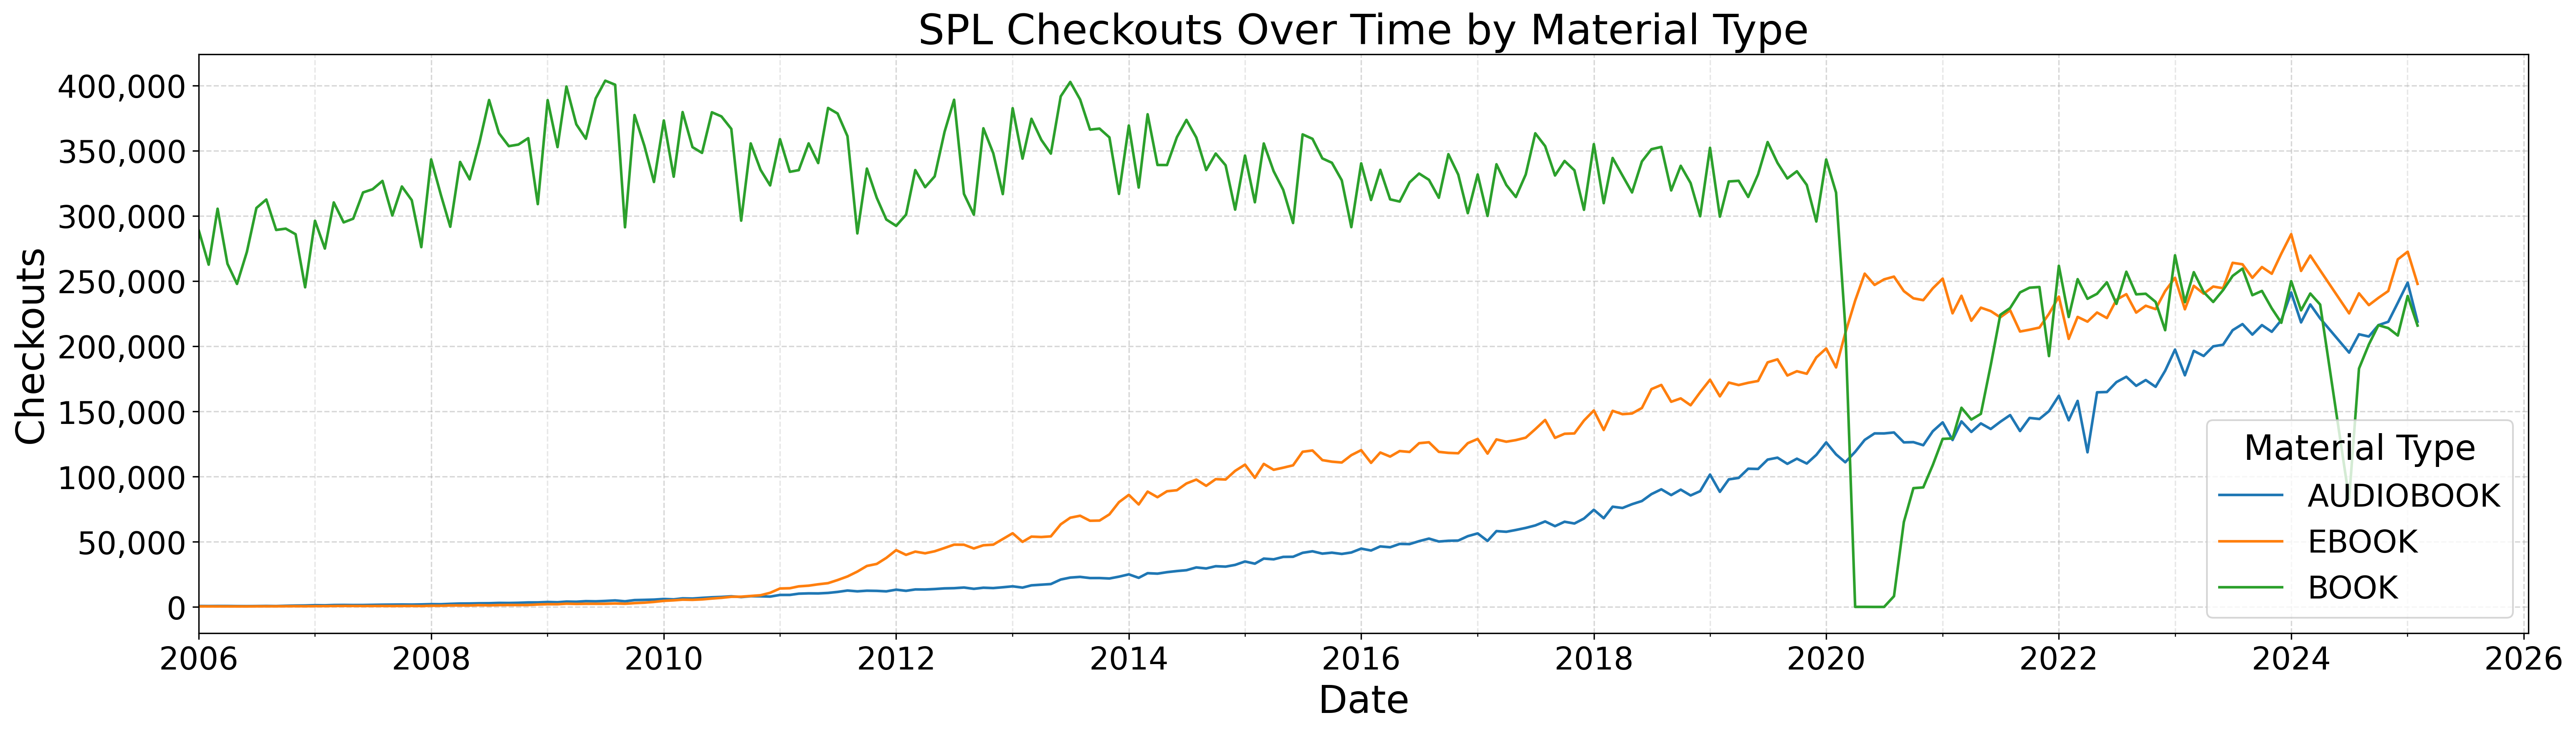

In [12]:
plt.figure(figsize=(24, 6), dpi=300)  # Adjust DPI for high-quality output
sns.lineplot(
    data=booktypebydate_pd,
    x="year-month",
    y="checkouts",
    hue="materialtype",
)

ax = plt.gca()
xticks = ax.get_xticks()
mid_xticks = (xticks[:-1] + xticks[1:]) / 2 
 # Major ticks
 # Midpoints as minor ticks
# Compute midpoints

# Apply midticks
ax.set_xticks(mid_xticks, minor=True)  # Add midpoints as minor ticks
plt.grid(True, which="minor", linestyle="--", alpha=0.3)

plt.xlim(left = min(booktypebydate_pd['year-month']))


# Formatting
plt.title("SPL Checkouts Over Time by Material Type", fontsize=24)
plt.xlabel("Date", fontsize=22)
plt.ylabel("Checkouts", fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(title="Material Type", fontsize=18, title_fontsize=20)
plt.grid(True, linestyle="--", alpha=0.5)

plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:,.0f}"))


### Here we extract the checkout numbers by year of physical, digital, and audiobooks

In [14]:
booktypebydate_pd[(booktypebydate_pd['year-month'] >= '2022-01-01') & (booktypebydate_pd['year-month'] < '2023-01-01')].groupby('materialtype').sum('checkouts')

,checkouts
materialtype,
AUDIOBOOK,1954869
BOOK,2877911
EBOOK,2736499


In [15]:
booktypebydate_pd[(booktypebydate_pd['year-month'] >= '2023-01-01') & (booktypebydate_pd['year-month'] < '2024-01-01')].groupby('materialtype').sum('checkouts')

,checkouts
materialtype,
AUDIOBOOK,2451377
BOOK,2921746
EBOOK,3025281


In [16]:
booktypebydate_pd[(booktypebydate_pd['year-month'] >= '2024-01-01') & (booktypebydate_pd['year-month'] < '2025-01-01')].groupby('materialtype').sum('checkouts')

,checkouts
materialtype,
AUDIOBOOK,2193482
BOOK,2055749
EBOOK,2515586


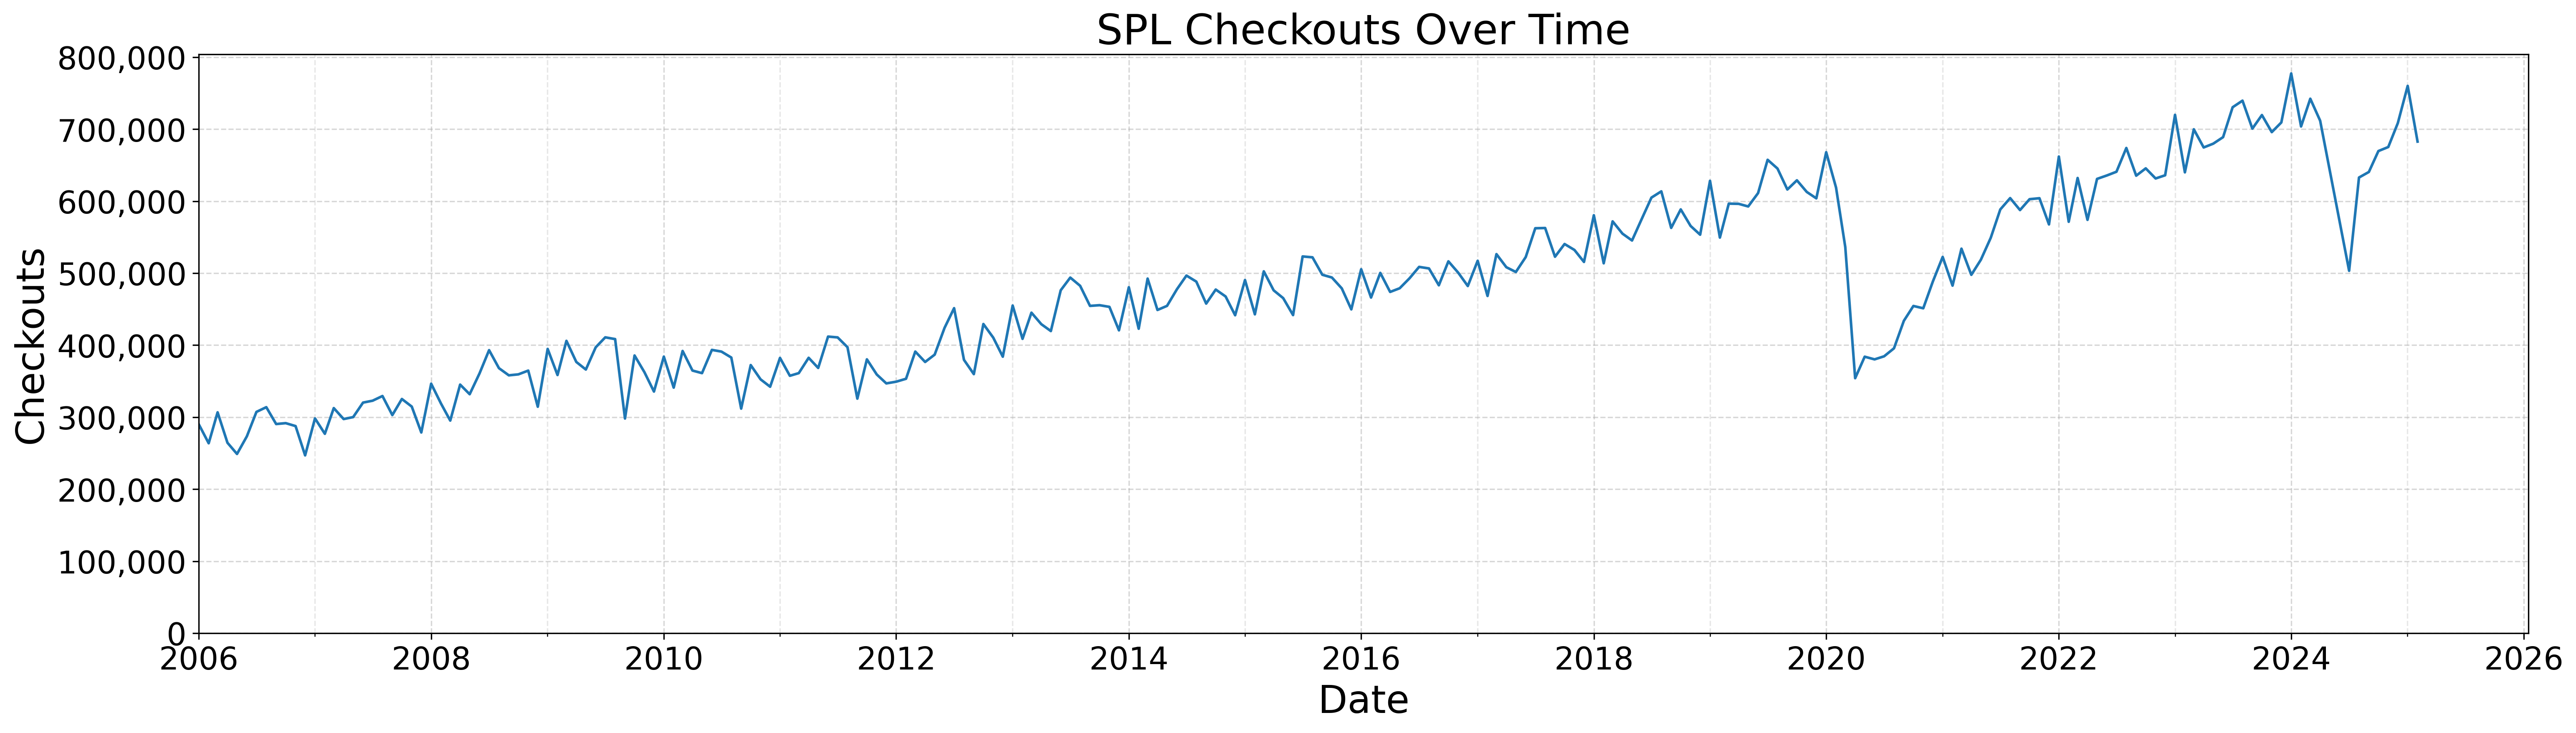

In [ ]:
agg_df = df.group_by("year-month").agg(
    pl.col("checkouts").sum().alias("total_checkouts")
)
agg_df = agg_df.sort(by='year-month')

plt.figure(figsize=(24, 6), dpi=300)  # Adjust DPI for high-quality output
sns.lineplot(
    data=agg_df,
    x="year-month",
    y="total_checkouts",
)

# Formatting
plt.xlim(left = min(booktypebydate_pd['year-month']))
plt.title("SPL Checkouts Over Time", fontsize=24)
plt.xlabel("Date", fontsize=22)
plt.ylabel("Checkouts", fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True, linestyle="--", alpha=0.5)
plt.ylim(bottom=0)

ax = plt.gca()
xticks = ax.get_xticks()
mid_xticks = (xticks[:-1] + xticks[1:]) / 2 
 # Major ticks
 # Midpoints as minor ticks
# Compute midpoints

# Apply midticks
ax.set_xticks(mid_xticks, minor=True)  # Add midpoints as minor ticks
plt.grid(True, which="minor", linestyle="--", alpha=0.3)

plt.xlim(left = min(booktypebydate_pd['year-month']))
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:,.0f}"))


### We now assemble our dataframe of popular books to analyze the distribution of checkouts by rank

In [30]:
df_2023 = df.filter(pl.col('checkoutyear') == 2023)
df_2022 = df.filter(pl.col('checkoutyear') == 2022)
df_2021 = df.filter(pl.col('checkoutyear') == 2021)
df_2024 = df.filter(pl.col('checkoutyear') == 2024)


In [31]:
ranks_21 = df_2021.group_by(['normalized_creator', 'normalized_title']) \
       .agg(pl.col('checkouts').sum()).sort(by = 'checkouts', descending = True)
ranks_22 = df_2022.group_by(['normalized_creator', 'normalized_title']) \
       .agg(pl.col('checkouts').sum()).sort(by = 'checkouts', descending = True)
ranks_23 = df_2023.group_by(['normalized_creator', 'normalized_title']) \
       .agg(pl.col('checkouts').sum()).sort(by = 'checkouts', descending = True)

ranks_21 = ranks_21 .with_columns(
    pl.arange(1, ranks_21.height + 1).alias("rank")
)
ranks_22 = ranks_22 .with_columns(
    pl.arange(1, ranks_22.height + 1).alias("rank")
)
ranks_23 = ranks_23 .with_columns(
    pl.arange(1, ranks_23.height + 1).alias("rank")
)

ranks_21 = ranks_21.with_columns(
    (pl.col("checkouts")*100 / pl.col("checkouts").sum()).alias("checkout_share")
)
ranks_22 = ranks_22.with_columns(
    (pl.col("checkouts")*100 / pl.col("checkouts").sum()).alias("checkout_share")
)
ranks_23 = ranks_23.with_columns(
    (pl.col("checkouts")*100 / pl.col("checkouts").sum()).alias("checkout_share")
)



In [32]:
fit_number = 1000

In [ ]:
ranks_21_pd = ranks_21.filter(pl.col("rank") <= fit_number).to_pandas()
ranks_22_pd = ranks_22.filter(pl.col("rank") <= fit_number).to_pandas()
ranks_23_pd = ranks_23.filter(pl.col("rank") <= fit_number).to_pandas()
ranks_21_pd['year'] = 2021
ranks_22_pd['year'] = 2022
ranks_23_pd['year'] = 2023


In [36]:
ranks_21_pd['year'] = 2021
ranks_22_pd['year'] = 2022
ranks_23_pd['year'] = 2023

/var/folders/0h/_q25zy451ylc2nnqm1jkshl80000gn/T/ipykernel_72058/235604039.py:2: UserWarning:

The palette list has more values (9) than needed (3), which may not be intended.



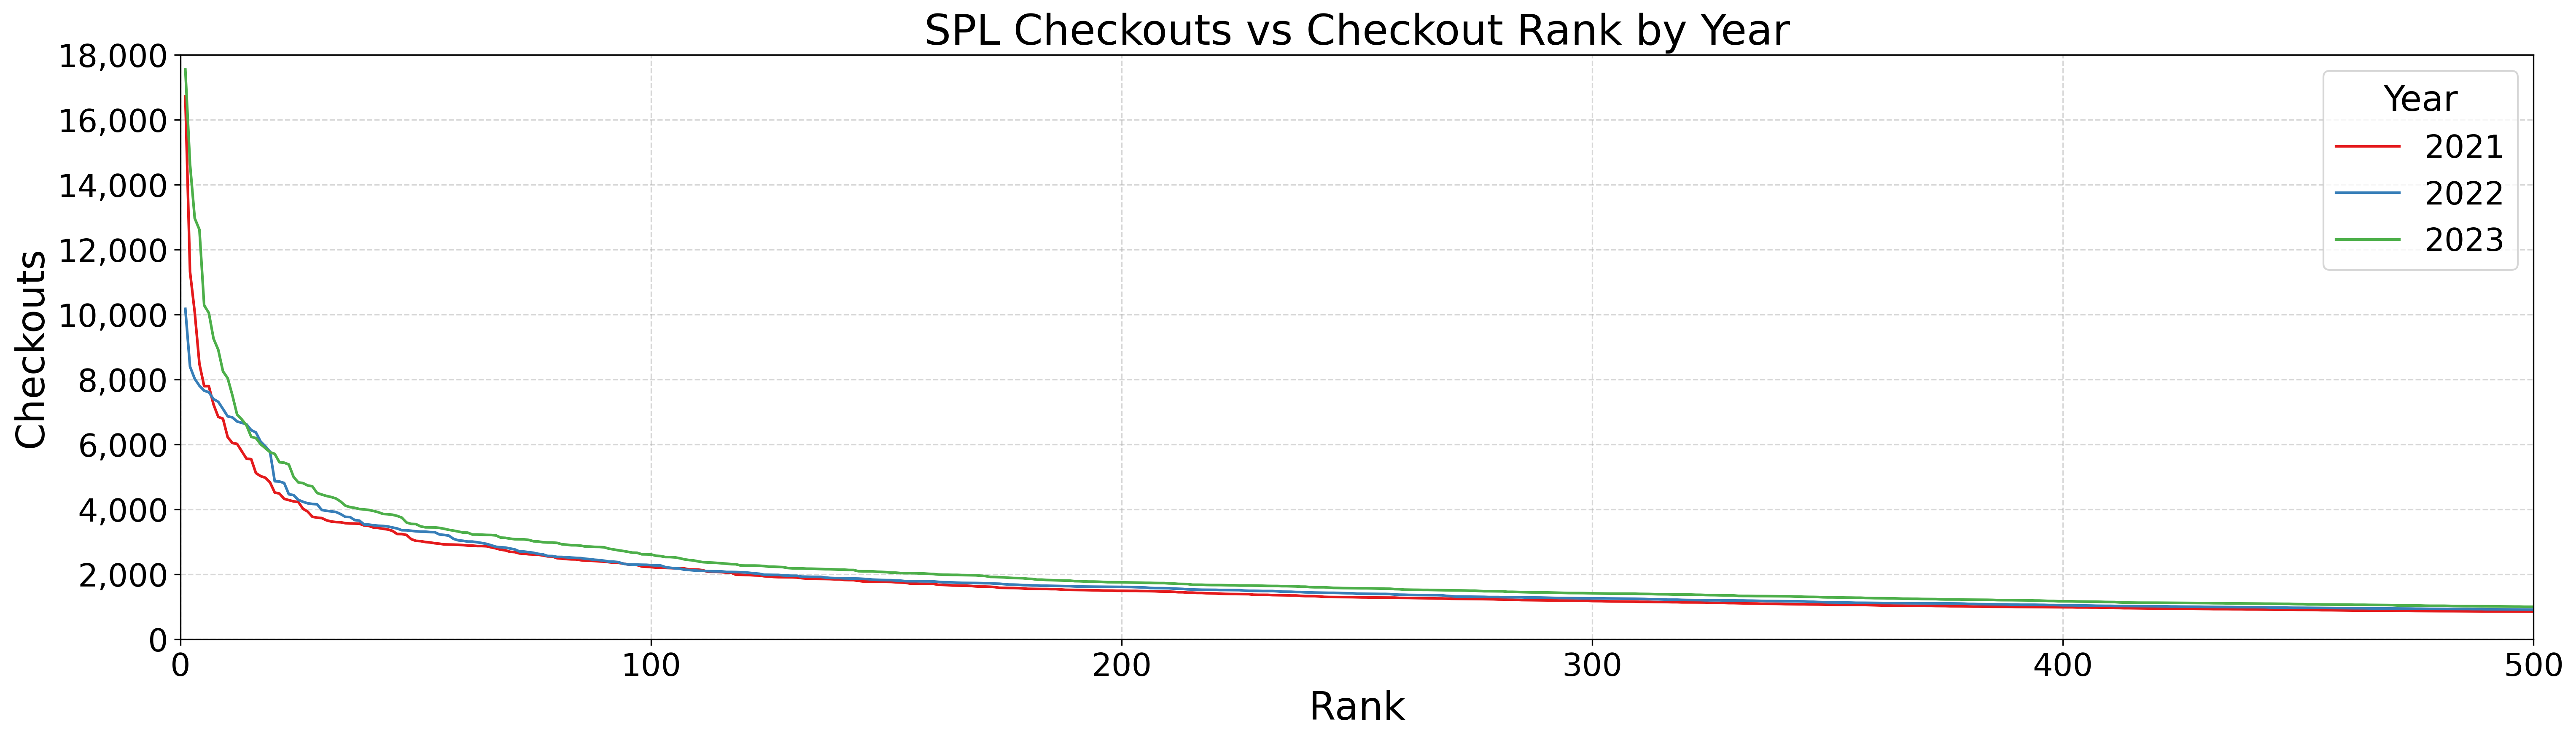

In [ ]:
ranks = pd.concat([ranks_21_pd, ranks_22_pd, ranks_23_pd])

plt.figure(figsize=(24, 6), dpi=300)  # Adjust DPI for high-quality output
sns.lineplot(
    data=ranks,
    x="rank",
    y="checkouts",
    hue="year",
    palette=sns.color_palette("Set1") 
)

# Formatting
plt.title("SPL Checkouts vs Checkout Rank by Year", fontsize=24)
plt.xlabel("Rank", fontsize=22)
plt.ylabel("Checkouts", fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim(left=0)
plt.xlim(right = 500)
plt.ylim(bottom = 0)
plt.ylim(top = 18000)
plt.legend(title="Year", fontsize=18, title_fontsize=20)
plt.grid(True, linestyle="--", alpha=0.5)
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:,.0f}"))

# Power Law Distribution Modeling


In [ ]:
x_data = ranks['rank'].to_numpy()
y_data = ranks['checkout_share'].to_numpy()

log_x = np.log(x_data)
log_y = np.log(y_data)

# Perform linear regression on log-log scale
slope, intercept, r_value, p_value, std_err = stats.linregress(log_x, log_y)


x_fit = x_data 
log_x_fit = np.log(x_fit)
# Compute predicted log_y
log_y_pred = intercept + slope * log_x

# Compute standard error of predictions
y_err = std_err * np.sqrt(1/len(x_data) + (log_x - np.mean(log_x))**2 / np.var(log_x))

# Convert back to original scale
y_pred = np.exp(log_y_pred)
ci_lower = np.exp(log_y_pred - 1.96 * y_err)  # 95% CI lower bound
ci_upper = np.exp(log_y_pred + 1.96 * y_err)  # 95% CI upper bound



In [126]:
a = np.exp(intercept)
b = slope
std_err_b = std_err
r_squared = r_value ** 2
p_val = p_value
n = len(x_data)

# Print values for LaTeX table
print(f"Intercept (a): {a:.4f}")
print(f"Slope (b): {b:.4f}")
print(f"Standard Error (b): {std_err_b:.4f}")
print(f"R^2: {r_squared:.4f}")
print(f"P-value: {p_val:.4e}")
print(f"Observations: {n}")

Intercept (a): 0.3937
Slope (b): -0.5572
Standard Error (b): 0.0012
R^2: 0.9871
P-value: 0.0000e+00
Observations: 3000


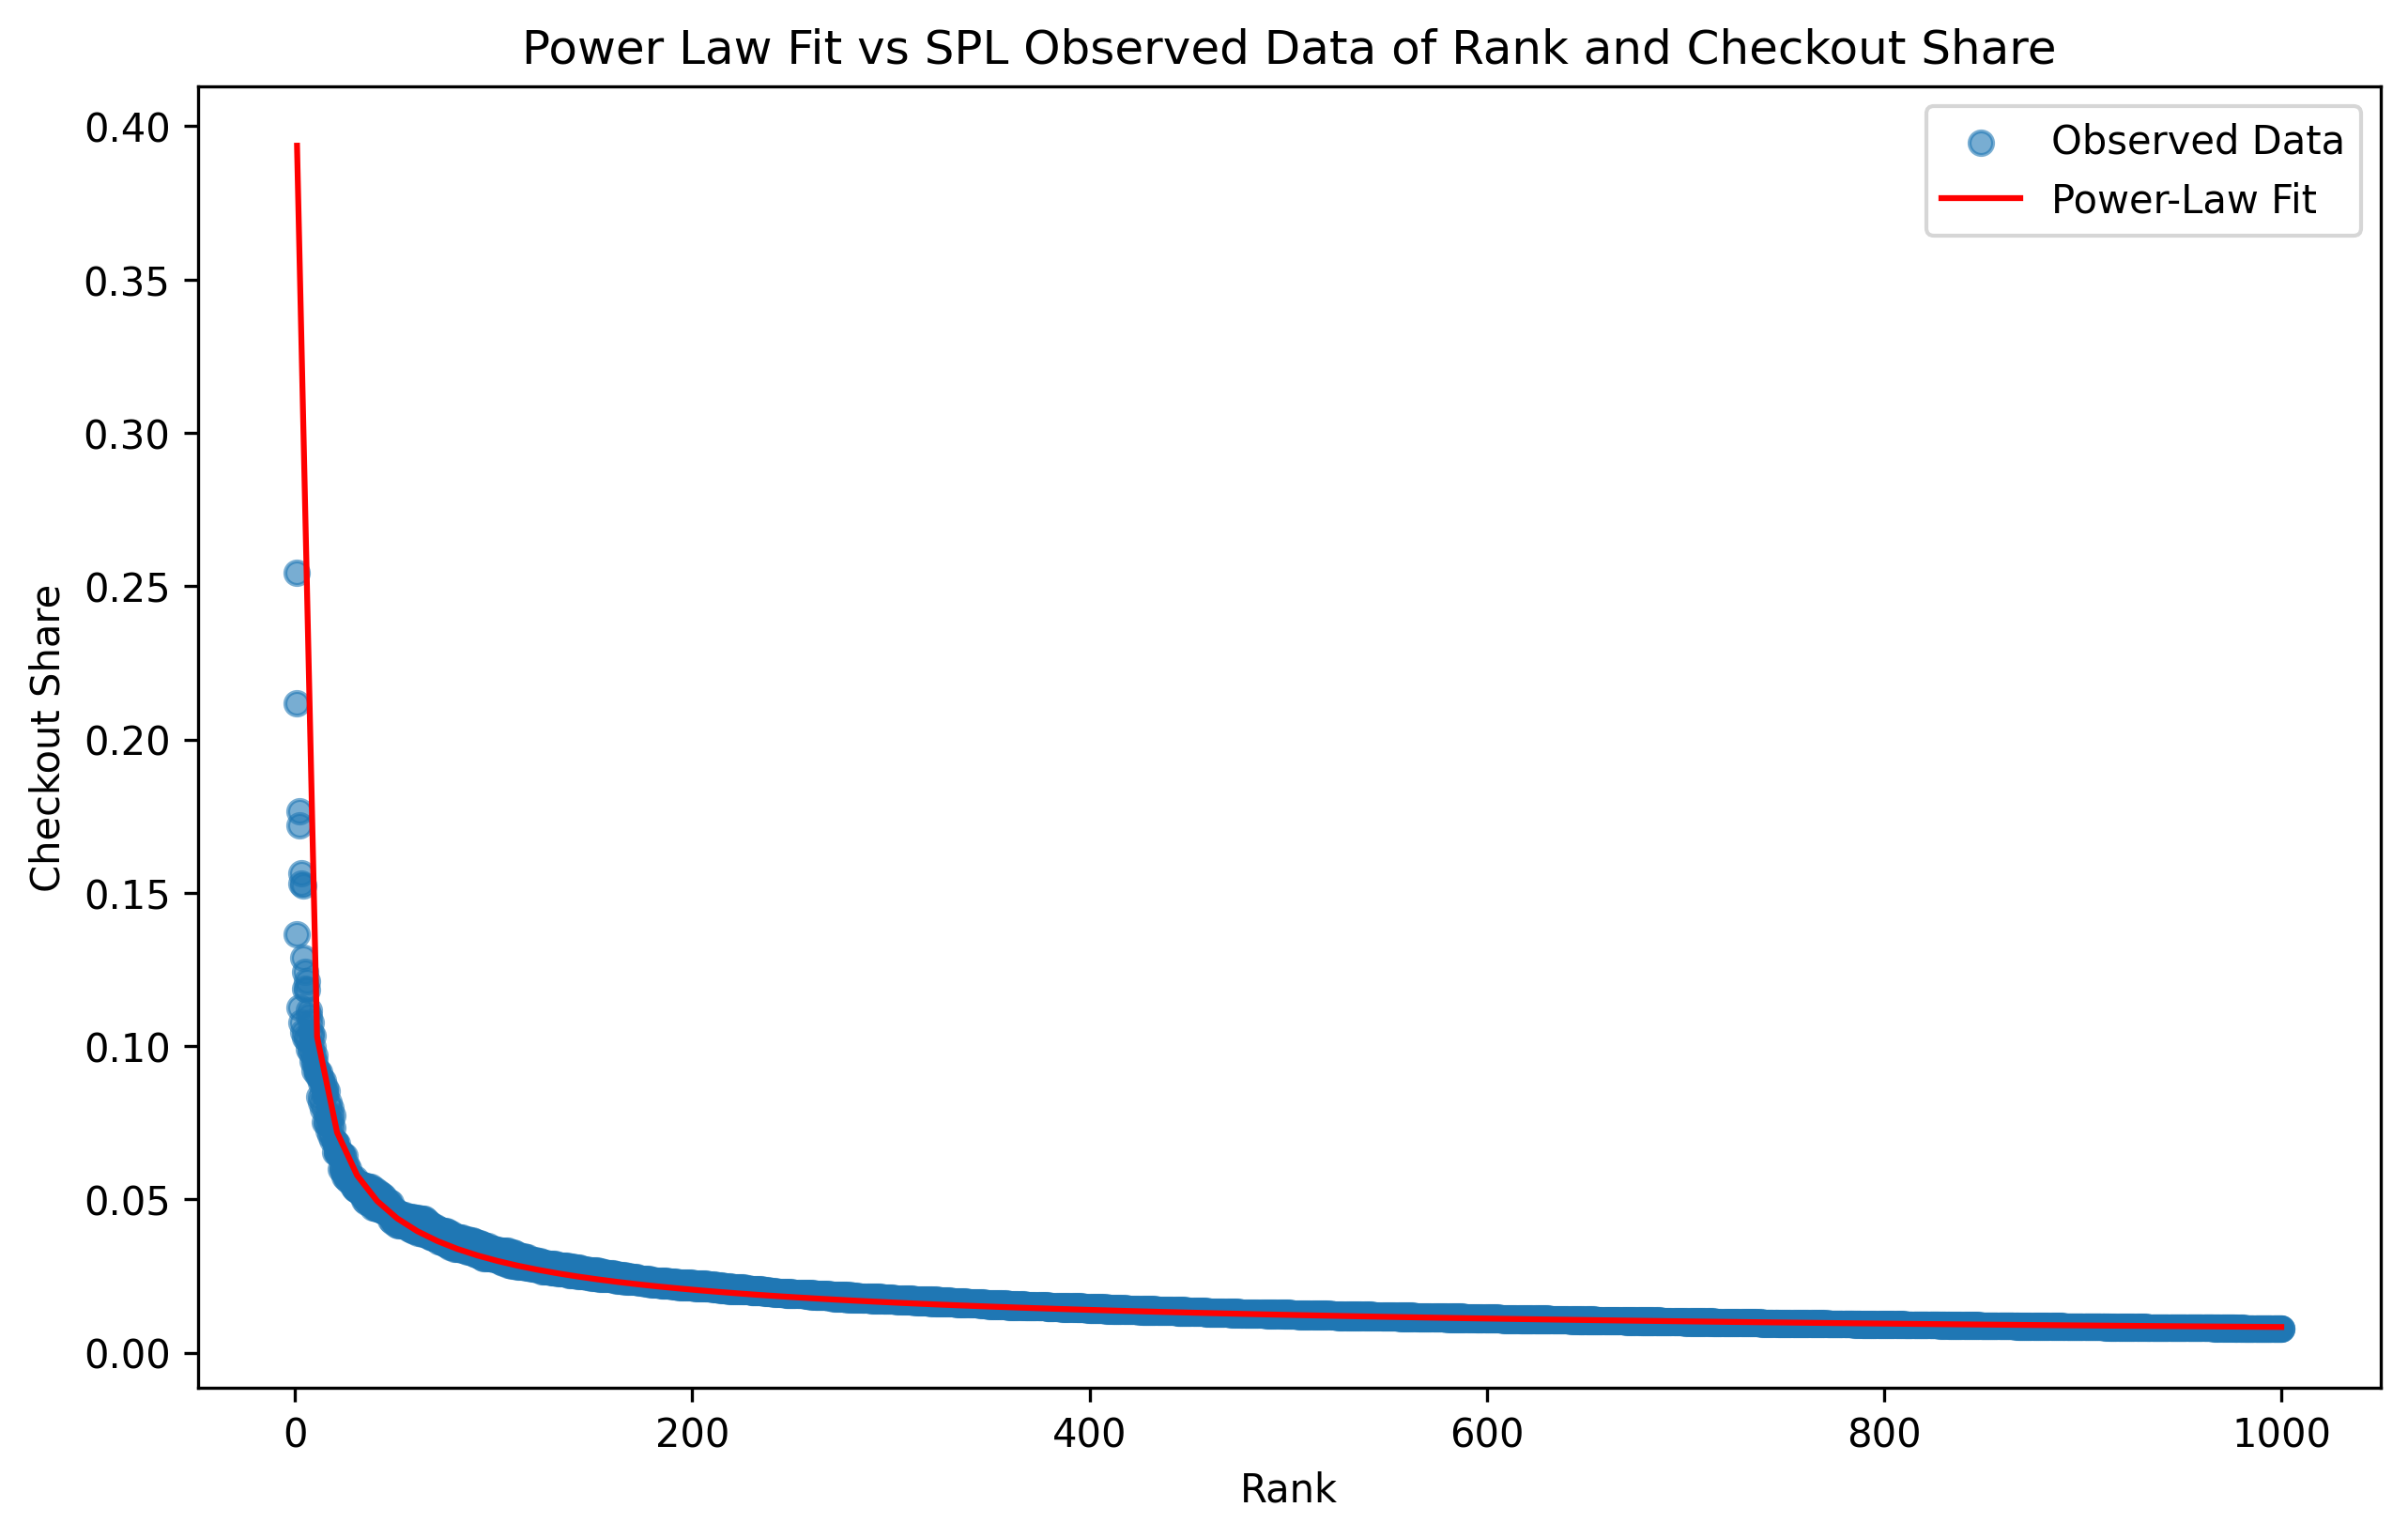

In [ ]:


# Ensure x_fit is a smooth range from min to max of x_data
x_fit = np.linspace(min(x_data), max(x_data), 100)

# Compute the power-law predicted values
y_pred = np.exp(intercept) * x_fit ** slope  # Power-law function

# Remove NaN or infinite values
valid_indices = np.isfinite(y_pred)
x_fit = x_fit[valid_indices]
y_pred = y_pred[valid_indices]

# Plotting
plt.figure(figsize=(10, 6), dpi=300)
plt.scatter(x_data, y_data, label="Observed Data", alpha=0.6)
plt.plot(x_fit, y_pred, label="Power-Law Fit", color="red")

# Labels and legend
plt.xlabel("Rank")
plt.ylabel("Checkout Share")
plt.legend()
plt.title("Power Law Fit vs SPL Observed Data of Rank and Checkout Share")

plt.show()


# Importing in the NYPL Top-10 List for Comparisons

In [39]:
nypl_21 = pd.read_csv("2021nypltop10.csv")
nypl_22 = pd.read_csv("2022nypltop10.csv")
nypl_23 = pd.read_csv("2023nypltop10.csv")

In [40]:

nypl_21['observed_share'] = nypl_21['SPL Number of Checkouts']*100 / ranks_21['checkouts'].sum()


nypl_22['observed_share'] = nypl_22['SPL Number of Checkouts']*100 / ranks_22['checkouts'].sum()


nypl_23['observed_share'] = nypl_23['SPL Number of Checkouts']*100 / ranks_23['checkouts'].sum()


In [41]:
nypl_21 = nypl_21.merge(ranks_21_pd[['rank', 'checkout_share']], 
                        left_on='NYPL Rank', right_on='rank', 
                        how='left').drop(columns=['rank']).rename(columns={'checkout_share': 'implied_share'})
nypl_22 = nypl_22.merge(ranks_22_pd[['rank', 'checkout_share']], 
                        left_on='NYPL Rank', right_on='rank', 
                        how='left').drop(columns=['rank']).rename(columns={'checkout_share': 'implied_share'})
nypl_23 = nypl_23.merge(ranks_23_pd[['rank', 'checkout_share']], 
                        left_on='NYPL Rank', right_on='rank', 
                        how='left').drop(columns=['rank']).rename(columns={'checkout_share': 'implied_share'})

In [43]:
nypl_21['SPL observed_share / NYPL implied_share'] = nypl_21['observed_share'] / nypl_21['implied_share']
nypl_22['SPL observed_share / NYPL implied_share'] = nypl_22['observed_share'] / nypl_22['implied_share']
nypl_23['SPL observed_share / NYPL implied_share'] = nypl_23['observed_share'] / nypl_23['implied_share']
df_all = pd.concat([nypl_21, nypl_22, nypl_23])

In [44]:
df_all[(df_all['SPL observed_share / NYPL implied_share'] > 0.8) & (df_all['SPL observed_share / NYPL implied_share'] < 1.2)]

,NYPL Rank,Title,Author,SPL Number of Checkouts,SPL Checkout Rank,observed_share,implied_share,SPL observed_share / NYPL implied_share
0,1,The Vanishing Half,Brit Bennett,16720,1,0.251065,0.251065,1.000000
4,5,Caste: The Origins of Our Discontents,Isabel Wilkerson,7796,7,0.117064,0.117079,0.999872
6,7,Where the Crawdads Sing,Delia Owens,6046,12,0.090786,0.108550,0.836354
2,3,The Lincoln Highway,Amor Towles,7809,4,0.103167,0.106007,0.973205
6,7,The Seven Husbands of Evelyn Hugo,Taylor Jenkins Reid,6835,11,0.090299,0.097737,0.923898
7,8,Book Lovers,Emily Henry,7095,9,0.093734,0.096641,0.969925
0,1,Lessons in Chemistry,Bonnie Garmus,17557,1,0.209052,0.209052,1.000000
1,2,"Tomorrow, and Tomorrow, and Tomorrow",Gabrielle Zevin,14632,2,0.174224,0.174224,1.000000
2,3,Spare,Prince Harry,12616,4,0.150219,0.154398,0.972931


# Generating the Braiding Sweetgrass Timeseries

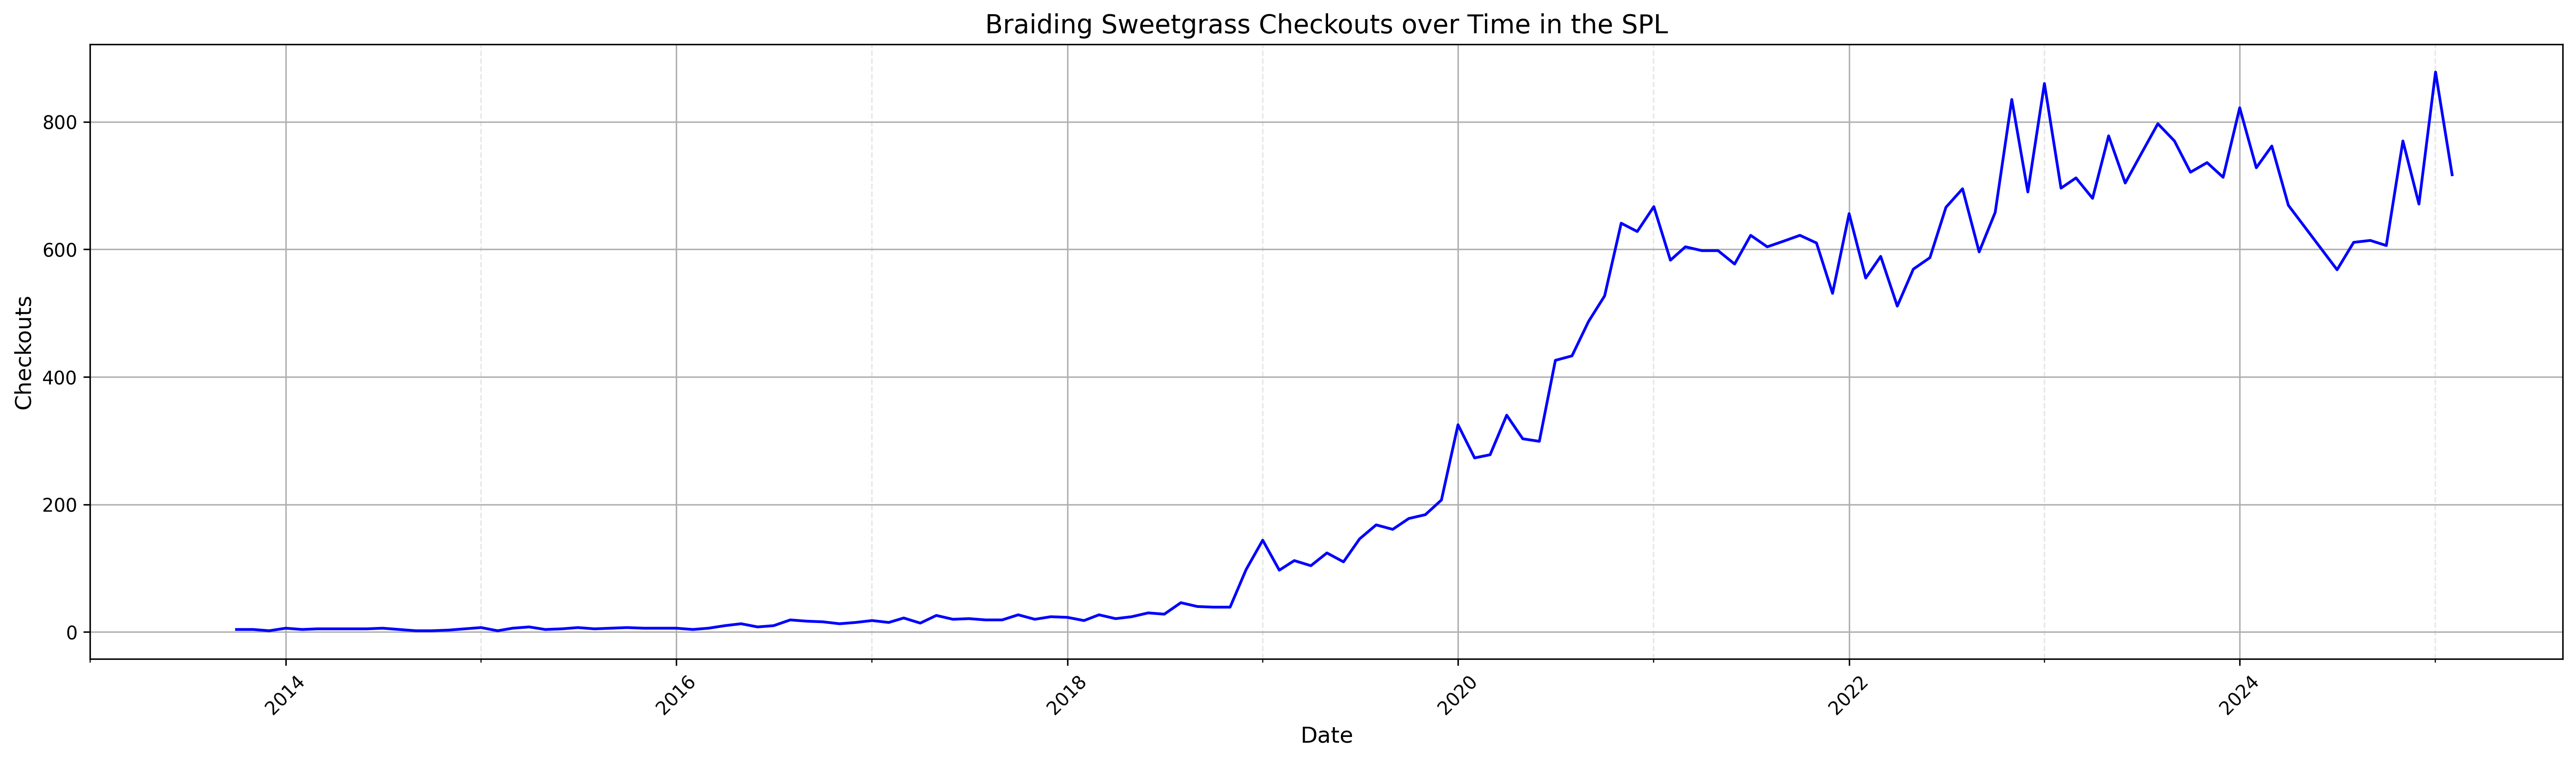

In [48]:
braiding_sweetgrass = df.filter(pl.col('normalized_creator') == 'robin wall kimmerer') \
  .filter(pl.col('normalized_title') == 'braiding sweetgrass') \
  .group_by(['normalized_title', 'year-month']) \
  .agg(pl.col('checkouts').sum().alias('total_checkouts'))

braiding_sweetgrass_pd = braiding_sweetgrass.sort('year-month').to_pandas()

plt.figure(figsize=(24, 6), dpi=300)

# Line plot for total checkouts over time
plt.plot(braiding_sweetgrass_pd['year-month'], braiding_sweetgrass_pd['total_checkouts'], label="Total Checkouts", color='blue')

# Set title and labels
plt.title("Braiding Sweetgrass Checkouts over Time in the SPL", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Checkouts", fontsize=12)
plt.xlim(min(braiding_sweetgrass_pd['year-month']))
plt.grid(True)
# Rotate x-axis labels for better readability (if necessary)

ax = plt.gca()
xticks = ax.get_xticks()
mid_xticks = (xticks[:-1] + xticks[1:]) / 2 
 # Major ticks
 # Midpoints as minor ticks
# Compute midpoints

# Apply midticks
ax.set_xticks(mid_xticks, minor=True)  # Add midpoints as minor ticks
plt.grid(True, which="minor", linestyle="--", alpha=0.3)
plt.xticks(rotation=45)

# Display the plot
plt.show()